# Census Income
---

#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

from sklearn import set_config
set_config(transform_output="pandas")

#### Import the data file

In [2]:
raw_df = pd.read_csv('files/datasets/adult.csv')
raw_df.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

Because values from the CSV file in Kaggle uses `?` as null values, we will replace those question marks with a NaN. 

In [3]:
raw_df.replace(to_replace='?', value=np.nan, inplace=True)

In [4]:
raw_df.replace(to_replace='<=50K', value=0, inplace=True)
raw_df.replace(to_replace='>50K', value=1, inplace=True)

#### View information about the dataframe

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [6]:
raw_df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

#### Split the data into target and features

In [7]:
def xy_split(dataframe, y_column):
    features = dataframe.loc[:, dataframe.columns != y_column]
    target = dataframe[y_column]
    return features, target

X, y = xy_split(raw_df, 'income')

##### Create training and testing sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Create a copy of the original dataset

In [9]:
df = X_train.copy()

---

# Data Preparation

#### Determine which columns have low cardinality
We will start fixing these columns first

In [10]:
def ohe_eligibility(datafame):
    for i in datafame.columns:
        if len(datafame[i].value_counts()) < 10:
            print(f'{len(datafame[i].value_counts())} - {i}')
        else:
            pass
        
ohe_eligibility(df)

8 - workclass
7 - marital.status
6 - relationship
5 - race
2 - sex


### Fixing Marital Status column
With encoding

In [11]:
df['marital.status'].value_counts(dropna=False)

Married-civ-spouse       11977
Never-married             8502
Divorced                  3582
Separated                  827
Widowed                    790
Married-spouse-absent      352
Married-AF-spouse           18
Name: marital.status, dtype: int64

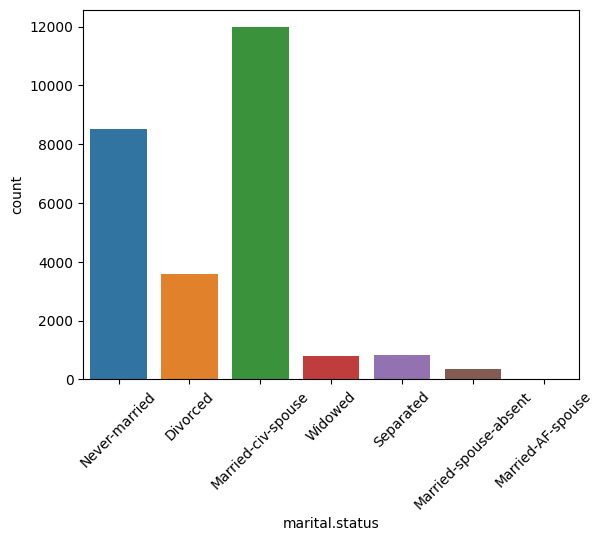

In [12]:
sns.countplot(x='marital.status', data=df)
plt.xticks(rotation=45)
plt.show()

Reduce categories by merging different categories into one.

Single: **Never Married**

Break: **Divorced**, **Widowed**, **Separated**

Married: **Married-civ-spouse**, **Married-spouse-absent**, **Married AF spouse**

In [13]:
replacements_dict = {"Never-married": "single", 
                     "Divorced": "break", 
                     "Separated": "break",
                     "Widowed": "break", 
                     "Married-civ-spouse": "married",
                     "Married-spouse-absent": "married", 
                     "Married-AF-spouse": "married",}

In [14]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer

# Define a custom function to replace a value in a dataframe
def replace_values(dataframe, column, replacements_dict):
    dataframe[column] = dataframe[column].replace(replacements_dict)
    return dataframe

# # Create a FunctionTransformer object
replace_transformer = FunctionTransformer(replace_values, kw_args={'column': 'marital.status', 'replacements_dict': replacements_dict})

# # # Apply the transformer to a example dataframe
# df_new = replace_transformer.transform(df)

# df_new.head()

# df_new['marital.status'].value_counts()

----

### Fixing Workclass column

In [15]:
df['workclass'].value_counts(dropna=False)

Private             18153
Self-emp-not-inc     2032
Local-gov            1680
NaN                  1436
State-gov            1062
Self-emp-inc          901
Federal-gov           766
Without-pay            12
Never-worked            6
Name: workclass, dtype: int64

Let's merge the categorical varaibles to reduce cardinality

In [16]:
replacements_dict_wc = {"Private": "P.Employed", 
                        "Self-emp-not-inc": "S.Employed", 
                        "Local-gov": "G.Employed",
                        "State-gov": "G.Employed", 
                        "Self-emp-inc": "S.Employed",
                        "Federal-gov": "G.Employed", 
                        "Without-pay": "P.Employed",
                        "Never-worked": "Unemployed"}

Private          - P.Employed         <br>
Self-emp-not-inc - S.Employed      <br>
Local-gov        - G.Employed       <br>
NaN              - NaN                <br>
State-gov        - G.Employed       <br>
Self-emp-inc     - S.Employed      <br>
Federal-gov      - G.Employed       <br>
Without-pay      - P.Employed           <br>
Never-worked     - Unemployed         <br>

In [17]:
raw_df_copy = raw_df.copy()

wc_df = replace_values(raw_df_copy, 'workclass', replacements_dict_wc)

In [18]:
wc_df.head()

age   workclass  fnlwgt     education  education.num marital.status  \
0   90         NaN   77053       HS-grad              9        Widowed   
1   82  P.Employed  132870       HS-grad              9        Widowed   
2   66         NaN  186061  Some-college             10        Widowed   
3   54  P.Employed  140359       7th-8th              4       Divorced   
4   41  P.Employed  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                NaN  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                NaN      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  income  
0          4356              40  United-States       0  
1          4356              18  United-States       0  
2          4356              40  United-States       0  
3          3900              40  United-States       0  
4          3900              40  United-States       0

In [19]:
wc_df['workclass'].value_counts(dropna=False)

P.Employed    22710
G.Employed     4351
S.Employed     3657
NaN            1836
Unemployed        7
Name: workclass, dtype: int64

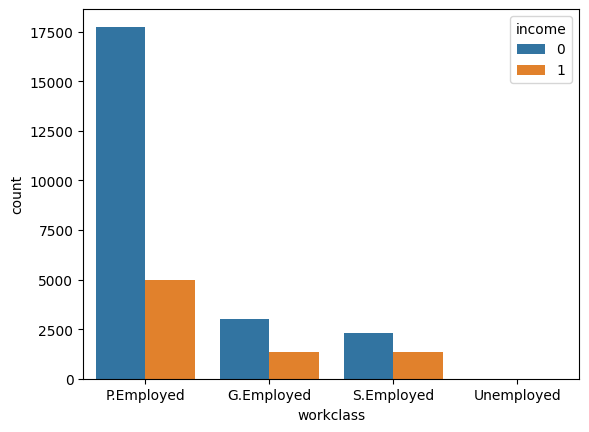

In [20]:
# Determine how workclass and income are nested
sns.countplot(x = 'workclass', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

In [21]:
# Use as a transformer

replace_transformer_wc = FunctionTransformer(replace_values, kw_args={'column': 'workclass', 'replacements_dict': replacements_dict_wc})

### Fixing Relationship column (NA)

In [22]:
wc_df['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

```
parent       - Husband        - husband sa kanyang family    <br>
no_family    - Not-in-family  - walang fam    <br>
no_family    - Own-child      - child sa kanyang fam    <br>
no_family    -Unmarried      - walang fam    <br>
parent       - Wife           - husband sa kanyang family    <br>
no_family    - Other-relative - walang fam    <br>

```

In [23]:
replacements_dict_r = {"Husband": "parent",           
                       "Not-in-family": "no_family",      
                       "Own-child": "no_family",   
                       "Unmarried": "no_family",  
                       "Wife": "parent",      
                       "Other-relative": "no_family"}

In [24]:
r_df = replace_values(wc_df, 'relationship', replacements_dict_r)

In [25]:
r_df

age   workclass  fnlwgt     education  education.num  \
0       90         NaN   77053       HS-grad              9   
1       82  P.Employed  132870       HS-grad              9   
2       66         NaN  186061  Some-college             10   
3       54  P.Employed  140359       7th-8th              4   
4       41  P.Employed  264663  Some-college             10   
...    ...         ...     ...           ...            ...   
32556   22  P.Employed  310152  Some-college             10   
32557   27  P.Employed  257302    Assoc-acdm             12   
32558   40  P.Employed  154374       HS-grad              9   
32559   58  P.Employed  151910       HS-grad              9   
32560   22  P.Employed  201490       HS-grad              9   

           marital.status         occupation relationship   race     sex  \
0                 Widowed                NaN    no_family  White  Female   
1                 Widowed    Exec-managerial    no_family  White  Female   
2                 Widowed                NaN    no_family  Black  Female   
3                Divorced  Machine-op-inspct    no_family  White  Female   
4               Separated     Prof-specialty    no_family  White  Female   
...                   ...                ...          ...    ...     ...   
32556       Never-married    Protective-serv    no_family  White    Male   
32557  Married-civ-spouse       Tech-support       parent  White  Female   
32558  Married-civ-spouse  Machine-op-inspct       parent  White    Male   
32559             Widowed       Adm-clerical    no_family  White  Female   
32560       Never-married       Adm-clerical    no_family  White    Male   

       capital.gain  capital.loss  hours.per.week native.country  income  
0                 0          4356              40  United-States       0  
1                 0          4356              18  United-States       0  
2                 0          4356              40  United-States       0  
3                 0          3900              40  United-States       0  
4                 0          3900              40  United-States       0  
...             ...           ...             ...            ...     ...  
32556             0             0              40  United-States       0  
32557             0             0              38  United-States       0  
32558             0             0              40  United-States       1  
32559             0             0              40  United-States       0  
32560             0             0              20  United-States       0  

[32561 rows x 15 columns]

In [26]:
replace_transformer_r = FunctionTransformer(replace_values, kw_args={'column': 'relationship', 'replacements_dict': replacements_dict_r})

---

### Apply function transformers as for loop

In [27]:
transformers = [(replace_transformer_r, 'relationship', replacements_dict_r),    
                (replace_transformer_wc, 'workclass', replacements_dict_wc),    
                (replace_transformer, 'marital.status', replacements_dict)]

for transformer, column, replacements_dict in transformers:
    replace_transformer = FunctionTransformer(replace_values, kw_args={'column': column, 'replacements_dict': replacements_dict})

In [28]:
# Data Before

raw_df_copy.head()

age   workclass  fnlwgt     education  education.num marital.status  \
0   90         NaN   77053       HS-grad              9        Widowed   
1   82  P.Employed  132870       HS-grad              9        Widowed   
2   66         NaN  186061  Some-college             10        Widowed   
3   54  P.Employed  140359       7th-8th              4       Divorced   
4   41  P.Employed  264663  Some-college             10      Separated   

          occupation relationship   race     sex  capital.gain  capital.loss  \
0                NaN    no_family  White  Female             0          4356   
1    Exec-managerial    no_family  White  Female             0          4356   
2                NaN    no_family  Black  Female             0          4356   
3  Machine-op-inspct    no_family  White  Female             0          3900   
4     Prof-specialty    no_family  White  Female             0          3900   

   hours.per.week native.country  income  
0              40  United-States       0  
1              18  United-States       0  
2              40  United-States       0  
3              40  United-States       0  
4              40  United-States       0

In [29]:
df_transformed = replace_transformer.fit_transform(raw_df_copy)

In [30]:
# Data after, it works

df_transformed.head()

age   workclass  fnlwgt     education  education.num marital.status  \
0   90         NaN   77053       HS-grad              9          break   
1   82  P.Employed  132870       HS-grad              9          break   
2   66         NaN  186061  Some-college             10          break   
3   54  P.Employed  140359       7th-8th              4          break   
4   41  P.Employed  264663  Some-college             10          break   

          occupation relationship   race     sex  capital.gain  capital.loss  \
0                NaN    no_family  White  Female             0          4356   
1    Exec-managerial    no_family  White  Female             0          4356   
2                NaN    no_family  Black  Female             0          4356   
3  Machine-op-inspct    no_family  White  Female             0          3900   
4     Prof-specialty    no_family  White  Female             0          3900   

   hours.per.week native.country  income  
0              40  United-States       0  
1              18  United-States       0  
2              40  United-States       0  
3              40  United-States       0  
4              40  United-States       0

### Create an initial pipeline

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
std_scl = StandardScaler()
oe_enc = OrdinalEncoder(handle_unknown='error')

In [33]:
count_process = ColumnTransformer([
    ('ohe', ohe_enc, ['marital.status', 'sex', 'relationship', 'race']),
    ('std-scale', std_scl, ['age', 'fnlwgt']), 
    ('passthrough', 'passthrough', ['education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'workclass'])
])

In [34]:
dt_primer = count_process.fit_transform(df_transformed)
dt_primer.head()

ohe__marital.status_break  ohe__marital.status_married  \
0                        1.0                          0.0   
1                        1.0                          0.0   
2                        1.0                          0.0   
3                        1.0                          0.0   
4                        1.0                          0.0   

   ohe__marital.status_single  ohe__sex_Female  ohe__sex_Male  \
0                         0.0              1.0            0.0   
1                         0.0              1.0            0.0   
2                         0.0              1.0            0.0   
3                         0.0              1.0            0.0   
4                         0.0              1.0            0.0   

   ohe__relationship_no_family  ohe__relationship_parent  \
0                          1.0                       0.0   
1                          1.0                       0.0   
2                          1.0                       0.0   
3                          1.0                       0.0   
4                          1.0                       0.0   

   ohe__race_Amer-Indian-Eskimo  ohe__race_Asian-Pac-Islander  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   ohe__race_Black  ohe__race_Other  ohe__race_White  std-scale__age  \
0              0.0              0.0              1.0        3.769612   
1              0.0              0.0              1.0        3.183112   
2              1.0              0.0              0.0        2.010110   
3              0.0              0.0              1.0        1.130359   
4              0.0              0.0              1.0        0.177296   

   std-scale__fnlwgt  passthrough__education.num  passthrough__capital.gain  \
0          -1.067997                           9                          0   
1          -0.539169                           9                          0   
2          -0.035220                          10                          0   
3          -0.468215                           4                          0   
4           0.709482                          10                          0   

   passthrough__capital.loss  passthrough__hours.per.week  \
0                       4356                           40   
1                       4356                           18   
2                       4356                           40   
3                       3900                           40   
4                       3900                           40   

  passthrough__workclass  
0                    NaN  
1             P.Employed  
2                    NaN  
3             P.Employed  
4             P.Employed

In [35]:
dt_primer.shape

(32561, 19)

In [36]:
dt_primer.isnull().sum().tail()

passthrough__education.num        0
passthrough__capital.gain         0
passthrough__capital.loss         0
passthrough__hours.per.week       0
passthrough__workclass         1836
dtype: int64

#### Random Forest as Imputer

In [37]:
# Accuracy Measure

def RandomForestImputerScore(dataframe, y_column):
    
    from sklearn.metrics import accuracy_score

    
    # Define the target and features
    df = dataframe.dropna(inplace=False)
    X = df.drop(y_column, axis=1, inplace=False)
    y = df[y_column]
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
    # Perform RandomForestClassifier
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    
    # Determine the accuracy of the model
    accuracy_score = accuracy_score(y_test, y_pred).round(3)
    
    return f'Accuracy: {accuracy_score}'

RandomForestImputerScore(dt_primer, 'passthrough__workclass')

'Accuracy: 0.713'

In [38]:
# Actual Implementation

def RandomForestImputer(dataframe, y_column):
    
    # Define the target and features
    df = dataframe.dropna(inplace=False)
    X = df.drop(y_column, axis=1, inplace=False)
    y = df[y_column]
    
    # Use all of the data as test set
    dfx_test = dataframe.drop(y_column, axis=1)
    dfy_test = dataframe[y_column]
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
    # Perform RandomForestClassifier
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(dfx_test)
    
    return pd.DataFrame(y_pred, columns=[y_column])

dt_primer.shape

(32561, 19)

In [39]:
try_lang = RandomForestImputer(dt_primer, 'passthrough__workclass')
try_lang

passthrough__workclass
0                 P.Employed
1                 P.Employed
2                 P.Employed
3                 P.Employed
4                 P.Employed
...                      ...
32556             P.Employed
32557             P.Employed
32558             P.Employed
32559             P.Employed
32560             P.Employed

[32561 rows x 1 columns]

In [40]:
# rf_imp = FunctionTransformer(RandomForestImputer, kw_args={'y_column': 'passthrough__workclass'})

### Fixing Occupation column

In [41]:
dfrfimputed = dt_primer.assign(workclass_imputed=try_lang, occupation=r_df['occupation'])
df_rf_drop = dfrfimputed.drop('passthrough__workclass', axis=1)

In [42]:
df_rf_drop

ohe__marital.status_break  ohe__marital.status_married  \
0                            1.0                          0.0   
1                            1.0                          0.0   
2                            1.0                          0.0   
3                            1.0                          0.0   
4                            1.0                          0.0   
...                          ...                          ...   
32556                        0.0                          0.0   
32557                        0.0                          1.0   
32558                        0.0                          1.0   
32559                        1.0                          0.0   
32560                        0.0                          0.0   

       ohe__marital.status_single  ohe__sex_Female  ohe__sex_Male  \
0                             0.0              1.0            0.0   
1                             0.0              1.0            0.0   
2                             0.0              1.0            0.0   
3                             0.0              1.0            0.0   
4                             0.0              1.0            0.0   
...                           ...              ...            ...   
32556                         1.0              0.0            1.0   
32557                         0.0              1.0            0.0   
32558                         0.0              0.0            1.0   
32559                         0.0              1.0            0.0   
32560                         1.0              0.0            1.0   

       ohe__relationship_no_family  ohe__relationship_parent  \
0                              1.0                       0.0   
1                              1.0                       0.0   
2                              1.0                       0.0   
3                              1.0                       0.0   
4                              1.0                       0.0   
...                            ...                       ...   
32556                          1.0                       0.0   
32557                          0.0                       1.0   
32558                          0.0                       1.0   
32559                          1.0                       0.0   
32560                          1.0                       0.0   

       ohe__race_Amer-Indian-Eskimo  ohe__race_Asian-Pac-Islander  \
0                               0.0                           0.0   
1                               0.0                           0.0   
2                               0.0                           0.0   
3                               0.0                           0.0   
4                               0.0                           0.0   
...                             ...                           ...   
32556                           0.0                           0.0   
32557                           0.0                           0.0   
32558                           0.0                           0.0   
32559                           0.0                           0.0   
32560                           0.0                           0.0   

       ohe__race_Black  ohe__race_Other  ohe__race_White  std-scale__age  \
0                  0.0              0.0              1.0        3.769612   
1                  0.0              0.0              1.0        3.183112   
2                  1.0              0.0              0.0        2.010110   
3                  0.0              0.0              1.0        1.130359   
4                  0.0              0.0              1.0        0.177296   
...                ...              ...              ...             ...   
32556              0.0              0.0              1.0       -1.215643   
32557              0.0              0.0              1.0       -0.849080   
32558              0.0              0.0              1.0        0.103983   
32559              0.0              0.0

In [43]:
count_process2 = ColumnTransformer(
    [('oe', oe_enc, ['workclass_imputed'])], 
    remainder = 'passthrough')

In [44]:
for_occu_primer = count_process2.fit_transform(df_rf_drop)
for_occu_primer.head(8)

oe__workclass_imputed  remainder__ohe__marital.status_break  \
0                    1.0                                   1.0   
1                    1.0                                   1.0   
2                    1.0                                   1.0   
3                    1.0                                   1.0   
4                    1.0                                   1.0   
5                    1.0                                   1.0   
6                    1.0                                   1.0   
7                    0.0                                   0.0   

   remainder__ohe__marital.status_married  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   
5                                     0.0   
6                                     0.0   
7                                     0.0   

   remainder__ohe__marital.status_single  remainder__ohe__sex_Female  \
0                                    0.0                         1.0   
1                                    0.0                         1.0   
2                                    0.0                         1.0   
3                                    0.0                         1.0   
4                                    0.0                         1.0   
5                                    0.0                         1.0   
6                                    0.0                         0.0   
7                                    1.0                         1.0   

   remainder__ohe__sex_Male  remainder__ohe__relationship_no_family  \
0                       0.0                                     1.0   
1                       0.0                                     1.0   
2                       0.0                                     1.0   
3                       0.0                                     1.0   
4                       0.0                                     1.0   
5                       0.0                                     1.0   
6                       1.0                                     1.0   
7                       0.0                                     1.0   

   remainder__ohe__relationship_parent  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  0.0   
4                                  0.0   
5                                  0.0   
6                                  0.0   
7                                  0.0   

   remainder__ohe__race_Amer-Indian-Eskimo  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
5                                      0.0   
6                                      0.0   
7                                      0.0   

   remainder__ohe__race_Asian-Pac-Islander  remainder__ohe__race_Black  \
0                                      0.0                         0.0   
1                                      0.0                         0.0   
2                                      0.0                         1.0   
3                                      0.0                         0.0   
4                                      0.0                         0.0   
5                                      0.0                         0.0   
6                                      0.0                         0.0   
7                                      0.0                         0.0   

   remainder__ohe__race_Other  remainder__ohe__race_White  \
0                         0.0                         1.0   
1                         0.0                         1.0   
2                         0.0                         0.0   
3       

In [45]:
for_occu_primer['remainder__occupation'].value_counts(dropna=False)

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
NaN                  1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: remainder__occupation, dtype: int64

In [47]:
replacements_dict_o = {"Prof-specialty": "managerial/professional",
                       "Exec-managerial": "managerial/professional",
                       "Adm-clerical": "technical/sales/administrative",
                       "Sales": "technical/sales/administrative",
                       "Tech-support": "technical/sales/administrative",
                       "Protective-serv": "service",
                       "Priv-house-serv": "service",
                       "Machine-op-inspct": "operator/fabricator/laborer",
                       "Transport-moving": "operator/fabricator/laborer",             
                       "Handlers-cleaners": "operator/fabricator/laborer"}

In [ ]:
replace_transformer_o = FunctionTransformer(replace_values, kw_args={'column': 'relationship', 'replacements_dict': replacements_dict_o})

In [48]:
RandomForestImputerScore(for_occu_primer, 'remainder__occupation')

'Accuracy: 0.265'

Try impute occupation by KNN imputing???

---

In [ ]:
raw_df_copy['marital.status'].value_counts()

In [ ]:
# Determine how workclass and income are nested
sns.countplot(x = 'relationship', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

### Fixing Occupation column (NA)

Let's try to impute this using columns from other data, we wil discover if it is possible to impute the `occupation` based on sex, race, education and workclass.

In [ ]:
wc_df['occupation'].value_counts(dropna=False)

In [ ]:
hs_grads = wc_df.loc[wc_df['education.num'] == 10]

In [ ]:
hs_grads.loc[hs_grads['occupation'].isna()]

In [ ]:
hs_grads['occupation'].value_counts()

### Fixing Race column (NA)

In [ ]:
wc_df['race'].value_counts(dropna=False)

In [ ]:
# Determine how workclass and income are nested
sns.countplot(x = 'race', 
              hue = 'income', 
              data = wc_df)
 
# Show the plot
plt.show()

In [ ]:
# Apply KNNImputing or MICE

In [ ]:
df['relationship'].value_counts(dropna=False)

Ano kinalaman neto?!

#### Explore KNNImputing

In [ ]:
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ms_pipe = make_pipeline(replace_transformer, ohe_enc)

In [ ]:
count_process = ColumnTransformer([ 
    ('ohe', ohe_enc, ['relationship', 'sex']), 
    ('repl_tf', ms_pipe, ['marital.status'])
])

In [ ]:
count_process.fit_transform(df)

### Next Task 

* How to apply FunctionTransformer inside a pipeline

* [ ] Age
* [ ] workclass
* [ ] fnlwght
* [ ] education
* [ ] education.num
* [X] martial.status
* [ ] occupation
* [X] relationship
* [ ] race
* [X] sex
* [ ] occupation
* [ ] capital.gain
* [ ] capital.loss
* [ ] hours.per.week
* [ ] native.country
* [ ] income

---